In [2]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config
import time
from ctapipe.image import number_of_island_sizes
from ctapipe.image import (
    hillas_parameters,
    leakage_parameters,
    concentration_parameters,
)
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates





In [3]:
cleaned_rings = [3403, 5120, 5397, 6317, 6448, 6466, 8234, 8448, 9044, 9151, 9217, 9360, 9404, 9433, 9435, 12432, 16110, 16379, 17309, 17494, 19103, 19358, 20105, 20229, 20349, 20402, 21288, 21433, 22126, 22205, 22365, 22390, 25287, 25345, 25432, 26113, 26164, 26347, 27167, 27176, 27374, 28000, 28320, 28328, 28449, 29266, 29390, 31123, 31176, 32064, 32342, 33057, 33302, 33315, 34219, 34347, 35052, 35219, 35375, 35435, 36231, 36452]
cleaned_shower = [28320, 28449]
muon_rings_cleaned = sorted(set(cleaned_rings).difference(set(cleaned_shower)))
print(len(set(cleaned_rings).difference(set(cleaned_shower))))
print(len(cleaned_rings))
print(sorted(set(cleaned_rings).difference(set(cleaned_shower))))

60
62
[3403, 5120, 5397, 6317, 6448, 6466, 8234, 8448, 9044, 9151, 9217, 9360, 9404, 9433, 9435, 12432, 16110, 16379, 17309, 17494, 19103, 19358, 20105, 20229, 20349, 20402, 21288, 21433, 22126, 22205, 22365, 22390, 25287, 25345, 25432, 26113, 26164, 26347, 27167, 27176, 27374, 28000, 28328, 29266, 29390, 31123, 31176, 32064, 32342, 33057, 33302, 33315, 34219, 34347, 35052, 35219, 35375, 35435, 36231, 36452]


In [4]:
arr04 = [2414, 3211, 3403, 4426, 6200, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 12334, 14335, 14402, 15185, 15405, 19103, 20229, 20402, 21288, 21433, 22053, 22205, 22271, 22390, 23382, 24482, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28034, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35219, 35375, 35435, 36231, 36364, 36452, 37363, 39094, 39152, 39376]
arr05 = [1018, 1018, 1149, 1321, 1389, 2363, 2414, 3198, 3211, 3403, 4426, 5363, 5425, 6200, 6317, 6376, 6376, 6417, 6419, 6466, 7176, 7418, 8234, 8316, 8323, 8369, 8448, 8473, 8487, 8490, 9318, 9404, 9433, 9435, 9444, 9486, 12061, 12162, 12262, 12305, 12334, 13320, 14214, 14335, 14390, 14402, 15185, 15196, 15405, 15447, 16213, 16471, 17000, 17168, 17168, 18137, 18291, 18476, 19103, 20120, 20229, 20356, 20402, 21281, 21288, 21433, 22053, 22053, 22123, 22205, 22271, 22354, 22364, 22390, 23382, 23419, 24294, 24482, 24482, 25051, 25345, 26113, 26164, 26336, 26338, 26347, 26365, 26374, 27176, 27281, 27374, 27414, 28000, 28034, 28328, 28341, 28357, 28372, 29213, 29266, 29372, 29390, 30181, 30291, 30405, 30447, 30462, 31042, 31043, 31123, 31176, 31332, 31332, 31333, 31386, 32064, 32256, 32298, 33057, 33071, 34115, 35052, 35103, 35219, 35296, 35375, 35376, 35393, 35435, 35444, 35472, 36231, 36364, 36452, 37363, 39083, 39094, 39152, 39376, 39401, 39444, 39466]
arr06 = [1018, 1018, 1087, 1149, 1281, 1321, 1389, 2080, 2086, 2363, 2388, 2414, 3146, 3198, 3211, 3380, 3403, 4054, 4054, 4070, 4339, 4367, 4426, 5218, 5218, 5363, 5425, 5454, 6171, 6200, 6242, 6317, 6376, 6376, 6417, 6419, 6433, 6466, 7176, 7418, 8055, 8141, 8234, 8316, 8323, 8369, 8448, 8473, 8487, 8490, 9074, 9168, 9236, 9318, 9339, 9369, 9393, 9404, 9412, 9422, 9433, 9435, 9444, 9478, 9478, 9486, 10083, 10396, 10406, 11001, 11252, 12013, 12025, 12030, 12061, 12162, 12162, 12262, 12305, 12334, 12336, 12386, 12386, 13202, 13320, 13332, 13408, 13421, 14214, 14335, 14390, 14402, 14406, 15185, 15196, 15348, 15405, 15433, 15447, 16110, 16213, 16338, 16379, 16398, 16399, 16422, 16424, 16462, 16471, 17000, 17168, 17168, 17356, 17422, 17446, 18026, 18137, 18237, 18291, 18351, 18413, 18447, 18476, 18476, 19103, 20120, 20229, 20356, 20402, 21104, 21250, 21281, 21288, 21353, 21433, 22053, 22053, 22088, 22123, 22127, 22205, 22271, 22354, 22364, 22365, 22373, 22390, 22415, 23054, 23238, 23285, 23382, 23392, 23419, 23435, 24272, 24294, 24294, 24353, 24353, 24374, 24471, 24482, 24482, 25051, 25345, 25371, 26113, 26164, 26193, 26336, 26338, 26347, 26365, 26374, 27176, 27195, 27281, 27374, 27383, 27414, 28000, 28034, 28110, 28320, 28328, 28341, 28342, 28357, 28372, 28449, 29072, 29213, 29266, 29313, 29372, 29372, 29390, 30152, 30181, 30291, 30405, 30447, 30462, 31042, 31043, 31063, 31123, 31176, 31332, 31332, 31333, 31361, 31386, 32064, 32100, 32256, 32275, 32298, 32366, 32434, 33057, 33071, 33151, 33240, 33383, 34115, 34126, 35052, 35099, 35103, 35133, 35219, 35294, 35296, 35375, 35376, 35392, 35393, 35435, 35444, 35470, 35470, 35470, 35472, 36231, 36260, 36331, 36364, 36452, 37091, 37107, 37363, 37383, 37402, 38106, 38191, 38209, 38337, 38351, 38398, 39083, 39094, 39094, 39121, 39152, 39372, 39376, 39401, 39444, 39466, 40182, 40387, 40411]
arr_ring06 = [3198, 14406, 16110, 16379, 22123, 22364, 22365, 22415, 25051, 25345, 34115] 
set_ring04 = {8448, 26113, 20229, 36231, 35219, 31386, 19103, 33057, 21288, 27176, 8234, 28328, 32298, 6317, 33071, 35375, 20402, 26164, 21433, 9404, 22205, 32064, 6466, 14402, 31176, 3403, 29390, 29266, 9433, 28000, 36452, 12262, 26347, 35052, 35435, 27374, 22390, 26365}

#print(sorted(set(arr06).difference(set(arr05))))
#print(sorted(set(arr_ring06).difference(set(arr06).difference(set(arr05)))))
print(sorted(set_ring04.union(set(arr_ring06))))
muon_rings_regular = sorted(set_ring04.union(set(arr_ring06)))
len(muon_rings_regular)

[3198, 3403, 6317, 6466, 8234, 8448, 9404, 9433, 12262, 14402, 14406, 16110, 16379, 19103, 20229, 20402, 21288, 21433, 22123, 22205, 22364, 22365, 22390, 22415, 25051, 25345, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 31176, 31386, 32064, 32298, 33057, 33071, 34115, 35052, 35219, 35375, 35435, 36231, 36452]


49

In [5]:
final_rings = list(set(muon_rings_cleaned).union(muon_rings_regular))
len(final_rings)
print(final_rings)

[5120, 8448, 9217, 25345, 26113, 20229, 36231, 20105, 22415, 9360, 12432, 31123, 35219, 5397, 33302, 31386, 17309, 19358, 19103, 27167, 33057, 33315, 21288, 27176, 8234, 28328, 34219, 6317, 34347, 35375, 6448, 26365, 20402, 32298, 26164, 33071, 21433, 9404, 22205, 9151, 32064, 6466, 14402, 34115, 14406, 25287, 31176, 3403, 29390, 29266, 9044, 17494, 32342, 25432, 9433, 9435, 22364, 22365, 25051, 28000, 36452, 12262, 26347, 35052, 35435, 16110, 22126, 27374, 22123, 22390, 16379, 20349, 3198]


In [5]:
muon_events = {}
for k in range(3,4):
    filename = f'/Users/vdk/Software/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    k_part = k*1000
    for i,j in enumerate(event_iterator):
        if (k_part + i) in muon_rings_regular:
            muon_events[k_part+i] = j
    print(f"new k = {k}")
            
        
        

new k = 3


In [6]:
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(
    image_extractor_type="GlobalPeakWindowSum",
    subarray = source.subarray)
for key in muon_events:
    calib(muon_events[key])
    image_processor(muon_events[key])
    muon_processor(muon_events[key])
    
    

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


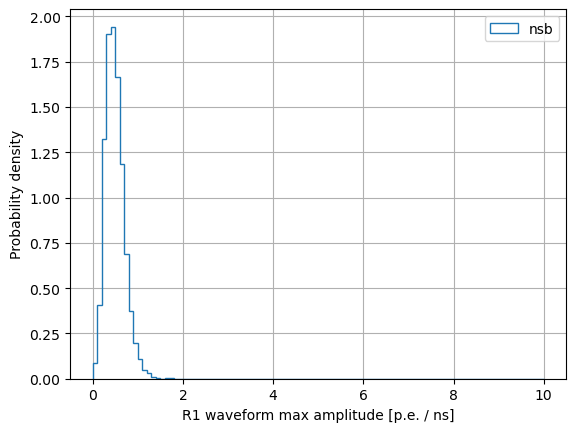

In [7]:
# NSB

nsb_scale = 10
filename = f'/Users/vdk/Dummy100_nsb_scaling_factor_{nsb_scale}.simtel.gz'
source = EventSource(filename, max_events=10)
event_iterator = iter(source)
arr_max_nsb = []

for event in event_iterator:
    for pixel in event.r1.tel[1].waveform:
        arr_max_nsb.append(np.max(pixel))

x,y,_ = plt.hist(arr_max_nsb, bins = 100, range = (0,10), density = True, alpha = 1, histtype = 'step', label = 'nsb')
plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()


In [1]:
# MUONS + NSB
arr_max_muons = []

for key in muon_events:
    for tel in muon_events[key].trigger.tels_with_trigger:
        if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency):
            for pixel in muon_events[key].r1.tel[tel].waveform:
                arr_max_muons.append(np.max(pixel))
            #arr_max.append(np.max(muon_events[key].r1.tel[tel].waveform))
k, z, l = plt.hist(arr_max_muons,bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'muons + muons/protons +nsb')
plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()


NameError: name 'muon_events' is not defined

<Figure size 640x480 with 0 Axes>

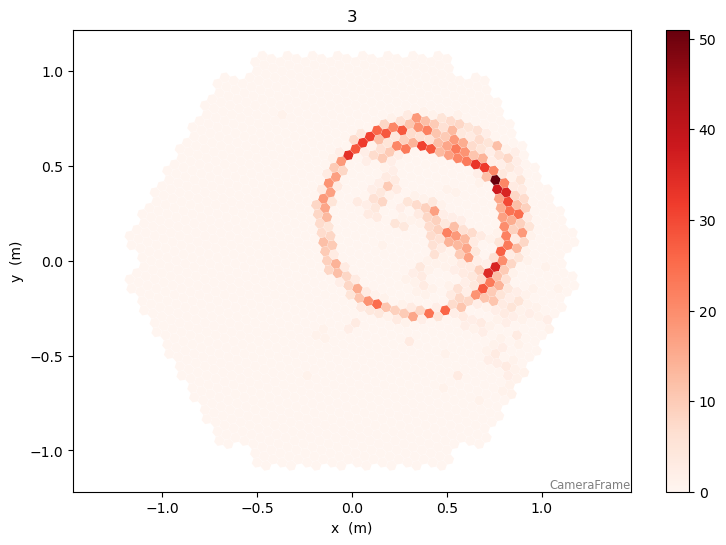

In [11]:

plt.figure()
tels = 1
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[tels].camera.geometry
title = f'{k}'
disp = CameraDisplay(camgeom,title=title)
disp.image = muon_events[3198].simulation.tel[tels].true_image
#disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
disp.cmap = plt.cm.Reds
disp.add_colorbar()
#disp.set_limits_percent(95)
plt.show()

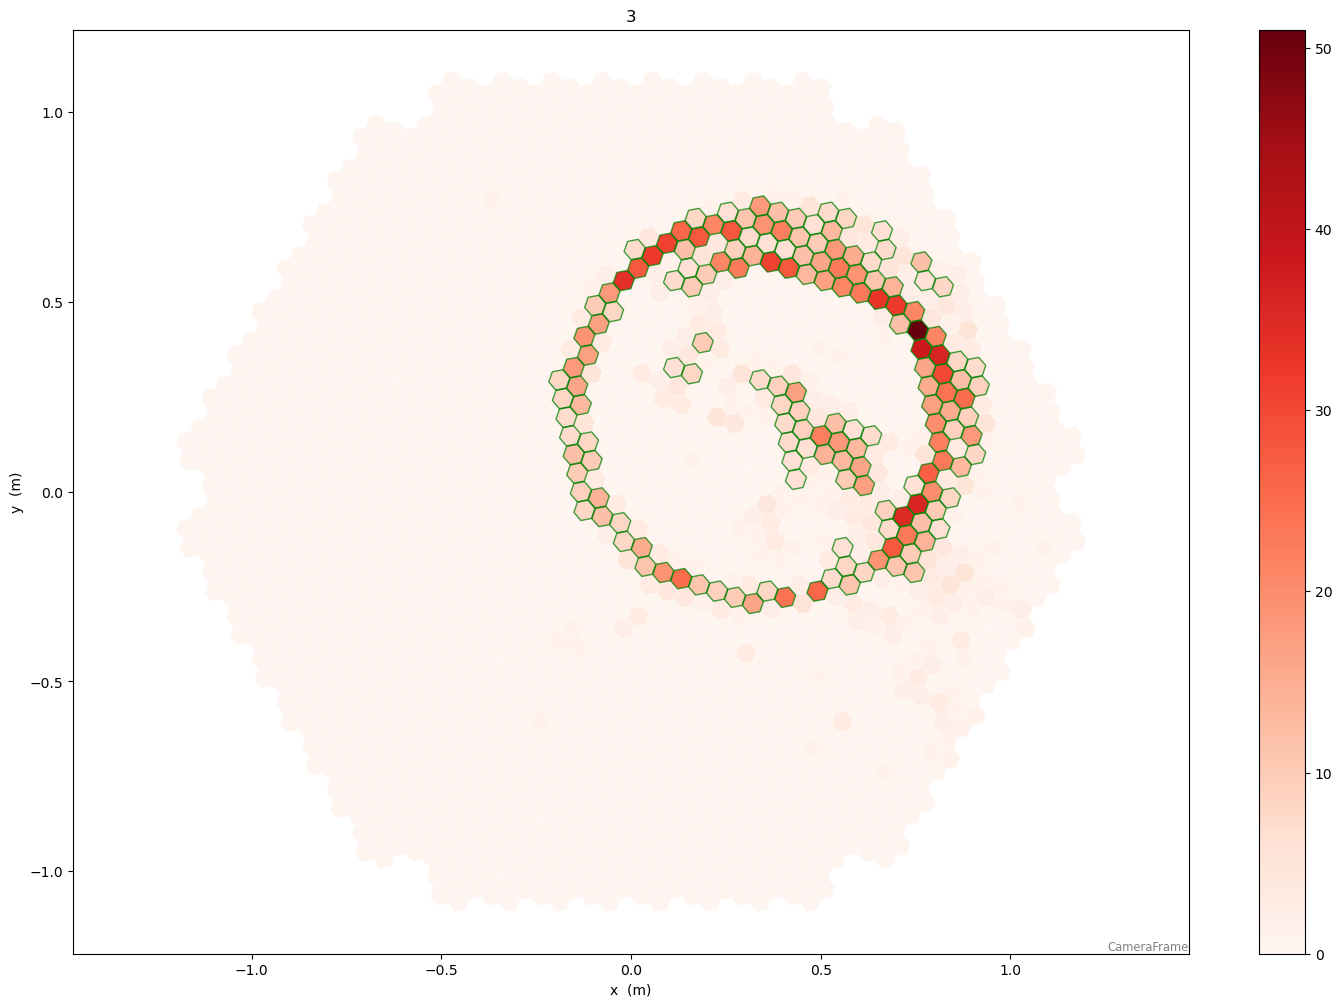

In [24]:
pixel_mask = np.array(muon_events[3198].simulation.tel[tels].true_image > 5, dtype = bool)
#plt.figure(figsize=(9,9))
tels = 1
plt.figure(figsize = (18,12))
camgeom = source.subarray.tel[tels].camera.geometry
title = f'{k}'
disp = CameraDisplay(camgeom,title=title)
disp.highlight_pixels(pixel_mask)
disp.image = muon_events[3198].simulation.tel[tels].true_image
#disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
disp.cmap = plt.cm.Reds
disp.add_colorbar()
#disp.set_limits_percent(95)
plt.show()

(array([42., 43., 28., 26., 10.,  8.,  3.,  0.,  3.,  1.]),
 array([ 0.70538139,  1.74215662,  2.77893186,  3.81570697,  4.85248232,
         5.88925743,  6.92603254,  7.96280766,  8.99958324, 10.03635788,
        11.07313347]),
 <BarContainer object of 10 artists>)

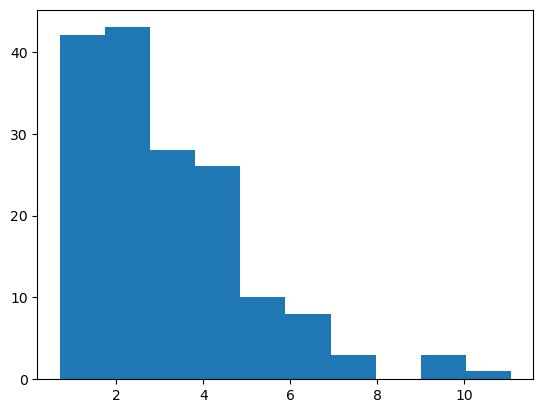

In [29]:
pixel_mask = np.array(muon_events[3198].simulation.tel[tels].true_image > 5, dtype = bool)
max_amplitude_vals = []
for pixel in muon_events[3198].r1.tel[1].waveform[pixel_mask, :]:
    max_amplitude_vals.append(np.max(pixel))

plt.hist(max_amplitude_vals)


### Pixel mask for only active pixels on simulated image

/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


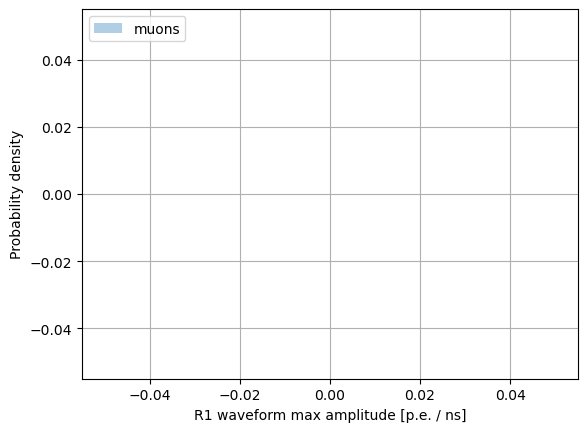

In [28]:
# MUONS PROTONS NSB

true_image_max_arr_m = []

for key in muon_events:
    for tel in muon_events[key].trigger.tels_with_trigger:
        if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency):
            pixel_mask = np.array(muon_events[key].simulation.tel[tel].true_image, dtype = bool)
            temp_event = muon_events[key].r1.tel[tel].waveform[pixel_mask, :]
            for waveform in temp_event:
                true_image_max_arr_m.append(np.max(waveform))

                #true_image_max_arr.append(np.max(muon_events[key].r1.tel[tel].waveform[pixel_mask, :], axis = 1))
            
true_image_max_arr_m = np.array(true_image_max_arr_m)

len(true_image_max_arr_m)
k, z, l = plt.hist(true_image_max_arr_m,bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'muons')
plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()

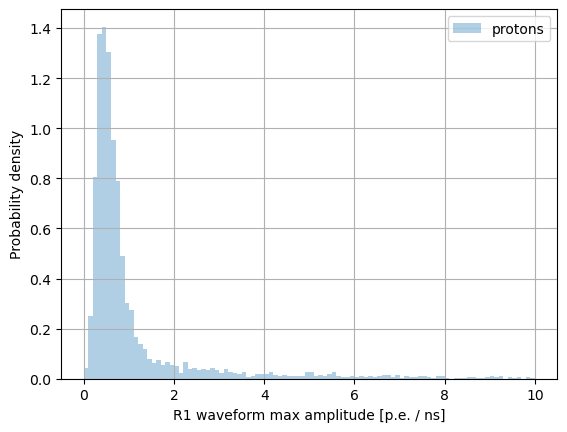

In [10]:
# PROTONS

k = 1
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=20)
event_iterator = iter(source)
arr_max_proton = []



true_image_max_arr_p = []

for event in event_iterator:
    for tel in event.trigger.tels_with_trigger:
        pixel_mask = np.array(event.simulation.tel[tel].true_image, dtype = bool)
        temp_event = event.r1.tel[tel].waveform[pixel_mask, :]
        for i in temp_event:
            true_image_max_arr_p.append(np.max(i))

true_image_max_arr_p = np.array(true_image_max_arr_p)

len(true_image_max_arr_p)

q,w,e = plt.hist(true_image_max_arr_p, bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'protons')
plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()

8376


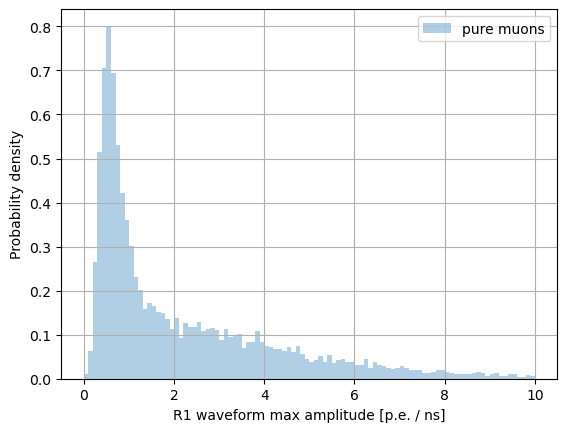

In [11]:
# PURE MUONS

pure_muons = [2414, 3211, 3403, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 14402, 15405, 19103, 20229, 20402, 21288, 21433, 22205, 22271, 22390, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35375, 36231, 36452, 37363, 39094, 39376]
true_image_max_arr_m_pure = []

for key in muon_events:
    if key in pure_muons:
        for tel in event.trigger.tels_with_trigger:
            if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency):
                pixel_mask = np.array(muon_events[key].simulation.tel[tel].true_image, dtype = bool)
                temp_event = muon_events[key].r1.tel[tel].waveform[pixel_mask, :]
                for i in temp_event:
                    true_image_max_arr_m_pure.append(np.max(i))

                #true_image_max_arr.append(np.max(muon_events[key].r1.tel[tel].waveform[pixel_mask, :], axis = 1))
                #np.max(muon_events[key].r1.tel[tel].waveform[pixel_mask, :], axis = 1)

            
true_image_max_arr_m_pure = np.array(true_image_max_arr_m_pure)

print(len(true_image_max_arr_m_pure))
r,t,y = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'pure muons')
plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()

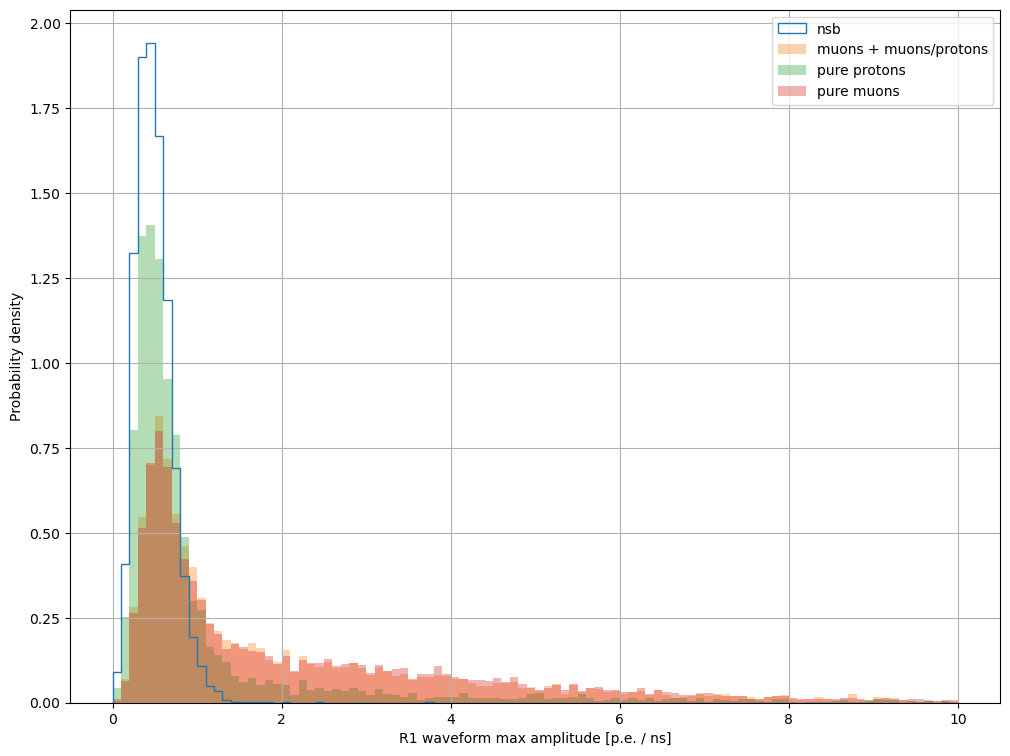

In [12]:
plt.figure(figsize = (12,9))
x,y,_ = plt.hist(arr_max_nsb, bins = 100, range = (0,10), density = True, alpha = 1, histtype = 'step', label = 'nsb')

#k, z, l = plt.hist(arr_max_muons,bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'muons + muons/protons +nsb')

a, b, c = plt.hist(true_image_max_arr_m,bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'muons + muons/protons')

q,w,e = plt.hist(true_image_max_arr_p,bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'pure protons')

r,t,y = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'pure muons')

plt.legend()
plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
plt.ylabel("Probability density")
plt.grid()

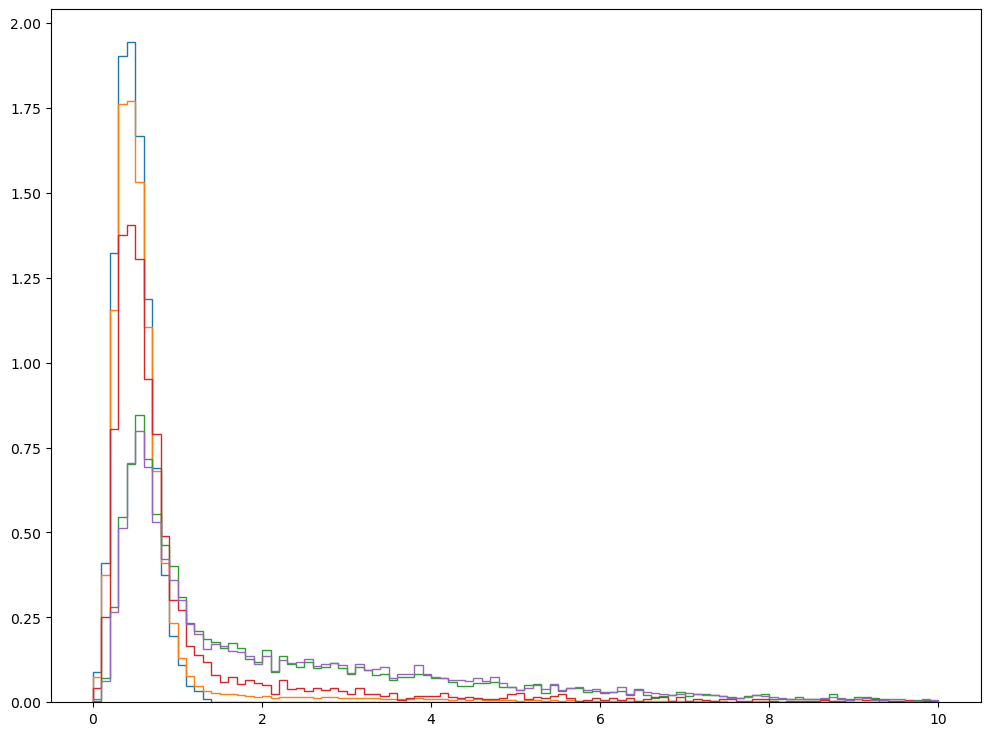

In [13]:
plt.figure(figsize = (12,9))
x,y,_ = plt.hist(arr_max_nsb, bins = 100, range = (0,10), density = True, alpha = 1, histtype = 'step', label = 'nsb')
k, z, l = plt.hist(arr_max_muons,bins = 100, range = (0,10), density = True, alpha = 1, label = 'muons + muons/protons +nsb', histtype = 'step')
a, b, c = plt.hist(true_image_max_arr_m,bins = 100, range = (0,10), density = True, alpha = 1, label = 'muons + muons/protons',histtype = 'step')
q,w,e = plt.hist(true_image_max_arr_p,bins = 100, range = (0,10), density = True, alpha = 1, label = 'pure protons',histtype = 'step')
r,t,y = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,10), density = True, alpha = 1, label = 'pure muons',histtype = 'step')



1254.7500498592854

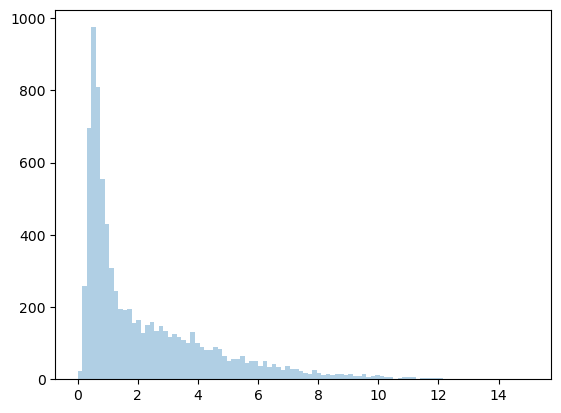

In [14]:
n, bins, _ = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,15), density = False, alpha = 0.35, label = 'pure muons')

bin_width = bins[1] - bins[0]
mask = np.where(bins > 2)

integral = bin_width * sum(n[mask[:-1]])
integral

In [15]:
sum(n)

8365.0

In [16]:
mask = np.array(np.where(bins > 2)[0])
n[mask[:-1]][-1]

0.0

In [17]:
arr = [1,2,3,4,5]

sum(arr[1:3])
sum(n[mask[:-1]])

3161.0

In [18]:
r1_cut = 2

array with number of pixels 37
pure muons =  46
counter =  8233
8233


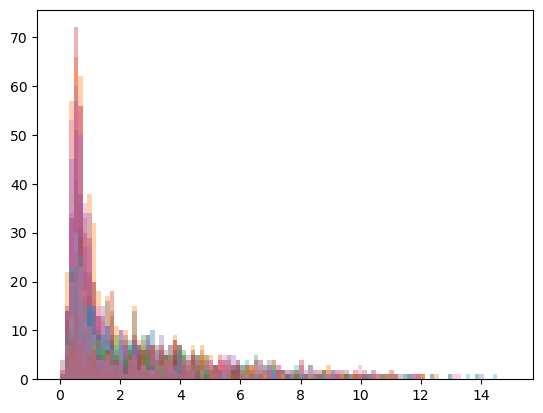

In [19]:
# PURE MUONS

pure_muons = [2414, 3211, 3403, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 14402, 15405, 19103, 20229, 20402, 21288, 21433, 22205, 22271, 22390, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35375, 36231, 36452, 37363, 39094, 39376]
pixel_number_arr_m_pure = []
counter = 0
all_arr = []
for key in muon_events:
    if key in pure_muons:
        temp_arr = []
        for tel in event.trigger.tels_with_trigger:
            if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency) and muon_events[key].muon.tel[tel].efficiency.optical_efficiency < 0.26:
                #print("key = ", key, "tel = ", tel)
                #print("optical eff = ", muon_events[key].muon.tel[tel].efficiency.optical_efficiency)
                pixel_mask = np.array(muon_events[key].simulation.tel[tel].true_image, dtype = bool)
                temp_event = muon_events[key].r1.tel[tel].waveform[pixel_mask, :]
                for i in temp_event:
                    temp_arr.append(np.max(i))
                counter += len(temp_arr)
                n, bins, _ = plt.hist(temp_arr, bins = 100, range = (0,15), density = False, alpha = 0.35, label = 'pure muons')
                mask = np.array(np.where(bins > r1_cut)[0])
                pixel_number_arr_m_pure.append(sum(n[mask[:-1]]))
            
#true_image_max_arr_m_pure = np.array(true_image_max_arr_m_pure)

print("array with number of pixels", len(pixel_number_arr_m_pure))
print("pure muons = ", len(pure_muons))
print("counter = ", counter)
#r,t,y = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'pure muons')
#plt.legend()
#plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
#plt.ylabel("Probability density")
#plt.grid()
print(counter)

In [20]:
# Protons pixel number


pixel_number_arr_p_pure = []
counter = 0

k = 1
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=30)
event_iterator = iter(source)
count = 0
all_arr = []

for k in range(1,2):
    filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
    source = EventSource(filename, max_events=30)
    event_iterator = iter(source)
    for event in event_iterator:
        for tel in event.trigger.tels_with_trigger:
            temp_arr = []
            count += 1
            pixel_mask = np.array(event.simulation.tel[tel].true_image, dtype = bool)
            temp_event = event.r1.tel[tel].waveform[pixel_mask, :]
            for i in temp_event:
                temp_arr.append(np.max(i))
                all_arr.append(np.max(i))
            #n, bins, _ = plt.hist(temp_arr, bins = 100, range = (0,15), density = False, alpha = 0.35, label = 'pure muons')
            hist = np.histogram(temp_arr, bins = 100, range = (0,15))
            mask = np.array(np.where(hist[1] > r1_cut)[0])
            pixel_number_arr_p_pure.append(sum(hist[0][mask[:-1]]))


#print("array with number of pixels", len(pixel_number_arr_p_pure))
#print("pure muons = ", len(pure_muons))
#print("counter = ", counter)
#pixel_number_arr_p_pure
#t = np.where(bins[:-1] > 2)[0]
#print("n = ", sum(n[t]))
#print("bins", bins[:-1])
print(pixel_number_arr_p_pure)
print(count)

[0, 12, 31, 16, 5, 1, 2, 5, 8, 0, 1, 1, 4, 1, 3, 1, 18, 26, 21, 9, 6, 7, 5, 110, 64, 114, 4, 10, 5, 6, 17, 23, 0, 3, 28, 7, 27, 5, 3, 26, 44, 13, 1, 2, 3, 3, 4]
47


In [21]:
pixel_number_arr_nsb = []
counter = 0
# NSB

nsb_scale = 10
filename = f'/Users/vdk/Dummy100_nsb_scaling_factor_{nsb_scale}.simtel.gz'
source = EventSource(filename, max_events=30)
event_iterator = iter(source)



for event in event_iterator:
    temp_arr = []  
    #print("t", event.r1.tel[1].waveform)
    for pixel in event.r1.tel[1].waveform:
        #print("here")
        temp_arr.append(np.max(pixel))
        #print(np.max(pixel))
        #print("nsb max = ", np.max(i))
    hist = np.histogram(temp_arr, bins = 100, range = (0,15))
    mask = np.array(np.where(hist[1] > r1_cut)[0])
    #print(np.where(hist[1] > r1_cut))
    pixel_number_arr_nsb.append(sum(hist[0][mask[:-1]]))
    
print("pix_number = ", pixel_number_arr_nsb)
#print(temp_arr)

pix_number =  [3, 2, 2, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 5, 2, 2, 5, 2, 2, 2, 3, 1, 2, 1, 1, 1, 4, 0, 2]


114


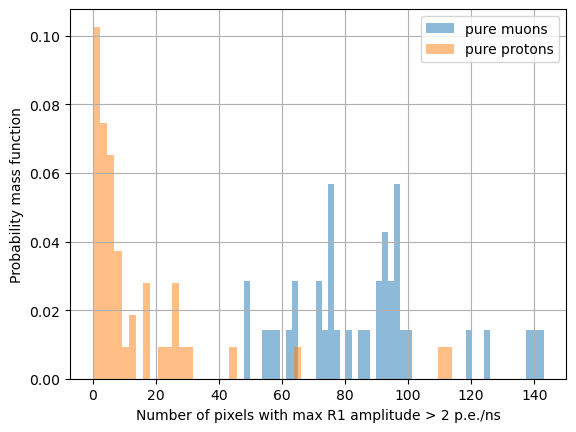

In [22]:
q,w,e = plt.hist(pixel_number_arr_m_pure, bins = 50, alpha = 0.5, label = 'pure muons', density = True)
r,t,y = plt.hist(pixel_number_arr_p_pure, bins = 50, alpha = 0.5, label = 'pure protons', density = True)
#r,t,y = plt.hist(pixel_number_arr_nsb, bins = 5, alpha = 0.5, label = 'nsb', density = True)

plt.legend()
plt.xlabel(f"Number of pixels with max R1 amplitude > {r1_cut} p.e./ns")
plt.ylabel("Probability mass function")
plt.grid()
#print(pixel_number_arr_m_pure)
#3print(pixel_number_arr_p_pure)
#print(pixel_number_arr_nsb)
print(max(pixel_number_arr_p_pure))

In [31]:
# Rewrite proton pixel number without hist

# Protons pixel number


pixel_number_arr_p_pure = []
counter = 0

k = 1
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=1000)
event_iterator = iter(source)
count = 0
r1_cut = 2


for k in range(1,41):
    filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    for event in event_iterator:
        if len(event.trigger.tels_with_trigger) > 1:
            for tel in event.trigger.tels_with_trigger:
                temp_arr = []
                count += 1
                pixel_mask = np.array(event.simulation.tel[tel].true_image, dtype = bool)
                temp_event = event.r1.tel[tel].waveform[pixel_mask, :]
                for i in temp_event:
                    temp_arr.append(np.max(i))
                temp_arr = np.array(temp_arr)
                #print("len arr ",len(temp_arr))            
                #print("len arr cut ",len(temp_arr[temp_arr>1]))
                pixel_number_arr_p_pure.append(len(temp_arr[temp_arr>r1_cut]))
                #n, bins, _ = plt.hist(temp_arr, bins = 100, range = (0,15), density = False, alpha = 0.35, label = 'pure muons')
                #hist = np.histogram(temp_arr, bins = 100, range = (0,15))
                #mask = np.array(np.where(hist[1] > r1_cut)[0])
                #pixel_number_arr_p_pure.append(sum(hist[0][mask[:-1]]))


#print("array with number of pixels", len(pixel_number_arr_p_pure))
#print("pure muons = ", len(pure_muons))
#print("counter = ", counter)
#pixel_number_arr_p_pure
#t = np.where(bins[:-1] > 2)[0]
#print("n = ", sum(n[t]))
#print("bins", bins[:-1])
#print(len(all_arr))
#print(count)
print(len(pixel_number_arr_p_pure))
#print(pixel_number_arr_p_pure)

25857


In [32]:
sorted_protons = np.array(sorted(pixel_number_arr_p_pure))
outlier = [sorted_protons[sorted_protons>200]]
outliers = [200 for i in outlier[0]]
wo_outlier = [sorted_protons[sorted_protons<200]]
arr_outlier = np.append(wo_outlier,outliers)
print(arr_outlier)
print(len(outliers))
print(len(wo_outlier))

outlier[0]

[  0   0   0 ... 200 200 200]
338
1


array([ 201,  201,  201,  201,  201,  201,  201,  201,  202,  202,  202,
        203,  203,  203,  203,  203,  204,  204,  204,  205,  205,  205,
        205,  206,  206,  206,  206,  206,  206,  207,  207,  208,  209,
        209,  209,  210,  210,  210,  210,  210,  211,  211,  212,  212,
        213,  213,  213,  213,  214,  214,  214,  214,  214,  215,  215,
        216,  216,  216,  216,  216,  217,  217,  218,  218,  218,  218,
        219,  219,  219,  219,  219,  220,  220,  220,  222,  222,  223,
        223,  224,  224,  224,  225,  225,  227,  227,  227,  228,  228,
        229,  229,  229,  229,  229,  230,  230,  230,  230,  230,  230,
        230,  230,  231,  232,  232,  232,  233,  233,  233,  235,  235,
        236,  236,  236,  237,  237,  238,  239,  239,  240,  240,  241,
        242,  242,  243,  244,  244,  245,  245,  246,  246,  246,  246,
        247,  248,  249,  250,  250,  251,  251,  251,  251,  251,  252,
        254,  255,  255,  256,  257,  257,  258,  2

1362
[120.0, 143.0, 78.0, 76.0, 96.0, 95.0, 124.0, 85.0, 82.0, 56.0, 92.0, 97.0, 100.0, 76.0, 76.0, 96.0, 90.0, 63.0, 71.0, 64.0, 76.0, 96.0, 93.0, 139.0, 140.0, 92.0, 87.0, 74.0, 72.0, 90.0, 58.0, 65.0, 54.0, 49.0, 48.0, 98.0, 94.0]


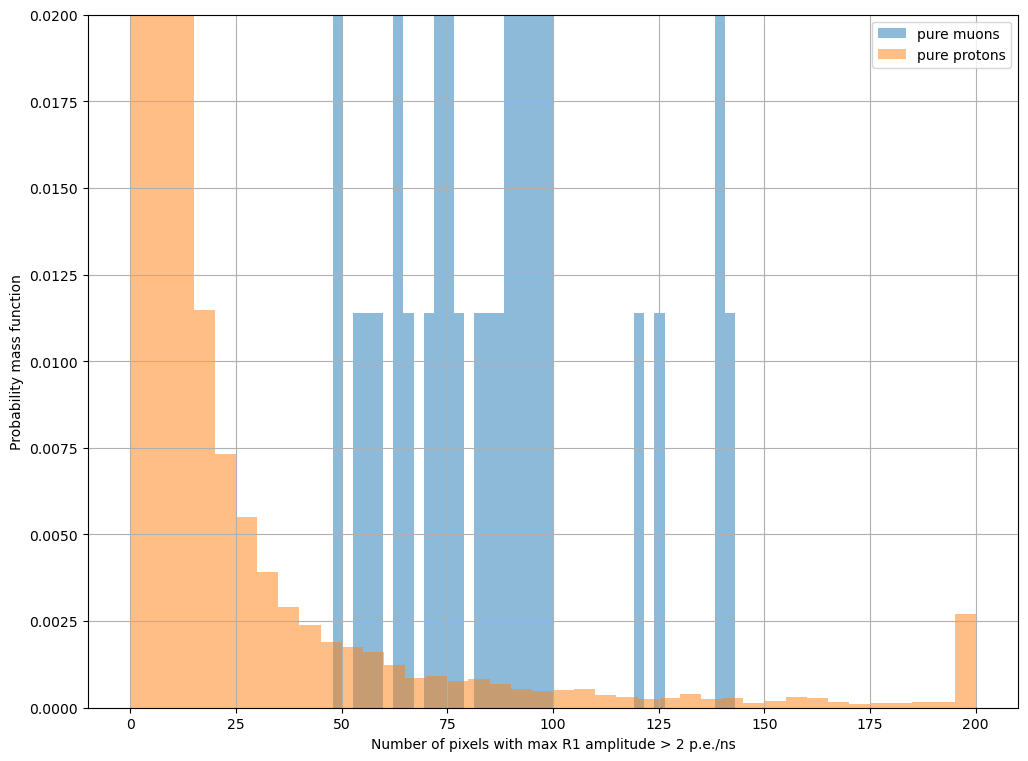

In [33]:
plt.figure(figsize = (12,9))
q,w,e = plt.hist(pixel_number_arr_m_pure, bins = 40, alpha = 0.5, label = 'pure muons', density = True)
#r,t,y = plt.hist(wo_outlier, bins = 50, alpha = 0.5, label = 'pure protons', density = True)
r,t,y = plt.hist(arr_outlier, bins = 40, alpha = 0.5, label = 'pure protons', density = True)

#r,t,y = plt.hist(pixel_number_arr_nsb, bins = 5, alpha = 0.5, label = 'nsb', density = True)


plt.legend()
plt.xlabel(f"Number of pixels with max R1 amplitude > {r1_cut} p.e./ns")
plt.ylabel("Probability mass function")
plt.ylim(0,0.02)
plt.grid()
#print(pixel_number_arr_m_pure)
#3print(pixel_number_arr_p_pure)
#print(pixel_number_arr_nsb)
print(max(pixel_number_arr_p_pure))
print(pixel_number_arr_m_pure)

In [ ]:
stop here

[1855, 121, 49, 35, 21, 20, 16, 14, 13, 11, 10, 10, 9]


(-100.0, 1900.0)

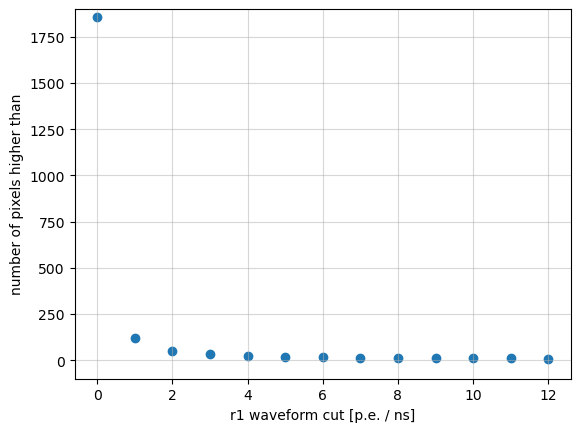

In [26]:
pure_muons = [2414, 3211, 3403, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 14402, 15405, 19103, 20229, 20402, 21288, 21433, 22205, 22271, 22390, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35375, 36231, 36452, 37363, 39094, 39376]
pixel_number_arr_m_pure = []
counter = 0
all_arr = []

r1_cuts = [0,1,2,3,4,5,6,7,8,9,10,11,12]
event = muon_events[3403]
cuts_values = []
temp = []

for tel in event.trigger.tels_with_trigger:
    if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency) and muon_events[key].muon.tel[tel].efficiency.optical_efficiency < 0.26:
        for cut in r1_cuts:
            temp = 0
            pixel_mask = np.array(event.simulation.tel[tel].true_image, dtype = bool)
            #temp_event = event.r1.tel[tel].waveform[pixel_mask, :]
            for pixel in event.r1.tel[tel].waveform:
                temp = np.append(temp, np.max(pixel))
            #temp = np.array(temp)
            cuts_values.append(len(temp[temp>cut]))
            #n, bins, _ = plt.hist(temp_arr, bins = 100, range = (0,15), density = False, alpha = 0.35, label = 'pure muons')
            #mask = np.array(np.where(bins > cut)[0])
            #cuts_values.append(sum(n[mask[:-1]]))
            


#print("array with number of pixels", len(pixel_number_arr_m_pure))
#print("pure muons = ", len(pure_muons))
#rint("counter = ", counter)
#r,t,y = plt.hist(true_image_max_arr_m_pure, bins = 100, range = (0,10), density = True, alpha = 0.35, label = 'pure muons')
#plt.legend()
#plt.xlabel("R1 waveform max amplitude [p.e. / ns]")
#plt.ylabel("Probability density")
#plt.grid()
print(cuts_values)
plt.scatter(r1_cuts,cuts_values)
plt.grid(alpha = 0.5)
plt.xlabel("r1 waveform cut [p.e. / ns]")
plt.ylabel("number of pixels higher than")
plt.ylim(-100,1900)

In [27]:
nsb_scale = 10
filename = f'/Users/vdk/Dummy100_nsb_scaling_factor_{nsb_scale}.simtel.gz'
source = EventSource(filename, max_events=10)
event_iterator = iter(source)
arr_max_nsb = []
event = next(event_iterator)
for pixel in event.r1.tel[1].waveform:
    print(np.mean(pixel))



#for event in event_iterator:
#    for pixel in event.r1.tel[1].waveform:
#        arr_max_nsb.append(np.max(pixel))

-0.102376245
-0.120866075
-0.011630708
-0.035178322
0.080608204
-0.08345052
0.03772328
-0.033825405
-0.023546271
0.026007231
-0.06418679
0.029098887
-0.053299297
0.17820856
-0.0060862703
-0.046956204
0.14461216
-0.0068820016
-0.0034251288
-0.0071449787
0.008411554
-0.01333186
-0.08916873
-0.00036748947
-0.06797762
-0.14802797
-0.03817045
-0.0873117
0.21750335
0.016055228
0.16940196
-0.13872048
0.08944426
-0.04953928
0.111983135
-0.0633565
0.07332669
0.042053323
-0.050947957
0.0611162
0.16565123
0.01274952
0.07124164
0.0019302696
-0.009395516
-0.10077181
-0.10384147
-0.046684884
0.030645777
-0.081223354
0.016535541
-0.03138063
0.016487878
0.017271996
-0.07045379
0.07728093
0.11075716
-0.06139066
-0.001005553
-0.07420335
-0.07298139
-0.05143421
0.08796092
-0.08059738
-0.07668565
-0.0072659464
0.08959646
-0.07236504
-0.046855718
-0.067079306
-0.010371101
0.11552224
-0.018655518
0.08237996
-0.043766625
0.0073864073
-0.07598661
-0.08374302
0.06931285
-0.03677299
-0.03521098
0.12904894
0.041

0
47
[3, 2, 2, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 5, 2, 2, 5, 2, 2, 2, 3, 1, 2, 1, 1, 1, 4, 0, 2]


/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


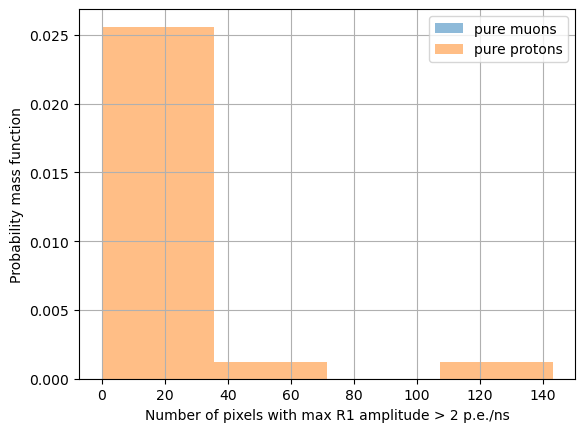

In [14]:
# ALL CASES PIXEL NUMBER

r1_cut = 2

pure_muons = [2414, 3211, 3403, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 14402, 15405, 19103, 20229, 20402, 21288, 21433, 22205, 22271, 22390, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35375, 36231, 36452, 37363, 39094, 39376]
pixel_number_arr_m_pure = []

for key in muon_events:
    if key in pure_muons:
        temp_arr = []
        for tel in [1,2,3,4]:
            if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency) and muon_events[key].muon.tel[tel].efficiency.optical_efficiency < 0.26:
                #print("key = ", key, "tel = ", tel)
                #print("optical eff = ", muon_events[key].muon.tel[tel].efficiency.optical_efficiency)
                pixel_mask = np.array(muon_events[key].simulation.tel[tel].true_image, dtype = bool)
                temp_event = muon_events[key].r1.tel[tel].waveform[pixel_mask, :]
                for i in temp_event:
                    temp_arr.append(np.max(i))
                counter += len(temp_arr)
                hist = np.histogram(temp_arr, bins = 100)
                mask = np.array(np.where(hist[1] > r1_cut)[0])
                pixel_number_arr_m_pure.append(sum(hist[0][mask[:-1]]))        
                    
# Protons pixel number


pixel_number_arr_p_pure = []
k = 1
filename = f'/Users/vdk/Software/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=30)
event_iterator = iter(source)
for event in event_iterator:
    for tel in event.trigger.tels_with_trigger:
        temp_arr = []
        pixel_mask = np.array(event.simulation.tel[tel].true_image, dtype = bool)
        temp_event = event.r1.tel[tel].waveform[pixel_mask, :]
        for i in temp_event:
            temp_arr.append(np.max(i))
        hist = np.histogram(temp_arr, bins = 100)
        mask = np.array(np.where(hist[1] > r1_cut)[0])
        pixel_number_arr_p_pure.append(sum(hist[0][mask[:-1]]))


pixel_number_arr_nsb = []
nsb_scale = 10
filename = f'/Users/vdk/LST/output_dummy_scan_4Sept_3/Dummy100_nsb_scaling_factor_{nsb_scale}.simtel.gz'
source = EventSource(filename, max_events=30)
event_iterator = iter(source)
for event in event_iterator:
    temp_arr = []  
    #print("t", event.r1.tel[1].waveform)
    for pixel in event.r1.tel[1].waveform:
        #print("here")
        temp_arr.append(np.max(pixel))
        #print(np.max(pixel))
        #print("nsb max = ", np.max(i))
    hist = np.histogram(temp_arr, bins = 100, range = (0,15))
    mask = np.array(np.where(hist[1] > r1_cut)[0])
    #print(np.where(hist[1] > r1_cut))
    pixel_number_arr_nsb.append(sum(hist[0][mask[:-1]]))
    
q,w,e = plt.hist(pixel_number_arr_m_pure, bins = 4, alpha = 0.5, label = 'pure muons', density = True)
r,t,y = plt.hist(pixel_number_arr_p_pure, bins = 4, alpha = 0.5, label = 'pure protons', density = True)
#r,t,y = plt.hist(pixel_number_arr_nsb, bins = 4, alpha = 0.5, label = 'nsb', density = True)

plt.legend()
plt.xlabel(f"Number of pixels with max R1 amplitude > {r1_cut} p.e./ns")
plt.ylabel("Probability mass function")
plt.grid()
print(len(pixel_number_arr_m_pure))
print(len(pixel_number_arr_p_pure))
print(pixel_number_arr_nsb)

In [10]:
pure_muons = [2414, 3211, 3403, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 14402, 15405, 19103, 20229, 20402, 21288, 21433, 22205, 22271, 22390, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35375, 36231, 36452, 37363, 39094, 39376]
pixel_number_arr_m_pure = []
counter = 0
for key in muon_events:
    if key in pure_muons:
        counter += 1
        temp_arr = []
        for tel in event.trigger.tels_with_trigger:
            if not np.isnan(muon_events[key].muon.tel[tel].efficiency.optical_efficiency):
                plt.figure(figsize = (9,6))
                camgeom = source.subarray.tel[tel].camera.geometry
                title=f"Event_{key}_optEff{round(muon_events[key].muon.tel[tel].efficiency.optical_efficiency,3)}_width{round(muon_events[key].muon.tel[tel].efficiency.width.to_value(),3)}_telescope{tel}"
                #title=f"CleanedRing_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
                disp = CameraDisplay(camgeom,title=title)
                disp.image = muon_events[key].simulation.tel[tel].true_image
                #disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
                disp.cmap = plt.cm.RdBu_r
                disp.add_colorbar()
                disp.set_limits_percent(95)
                #plt.show()

NameError: name 'event' is not defined

In [30]:
filename = f'/Users/vdk/Dummy100_nsb_scaling_factor_{nsb_scale}.simtel.gz'
source = EventSource(filename, max_events=1)
event_iterator = iter(source)
arr_max_test = []

for event in event_iterator:
    for pixel in event.r1.tel[1].waveform:
        arr_max_test.append(np.max(np.max(pixel)))
        
len(arr_max_test)

1855

In [31]:
1+2

3

In [32]:
###
# Algorithm to process events and try to calibrate them
###
int_cut = 0.3
min_pixel = 80

muon_processor_config = Config({"MuonProcessor": 
                                {"RingQuery": 
                                 {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.5"],
                                                        ["ring_completeness", "parameters.completeness > 0.5"]]}}})

#muon_processor_config = Config({"MuonProcessor":
#                                {"ImageParameterQuery" :
#                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

muon_processor_config_2 = Config({"MuonProcessor":
                                {"ImageParameterQuery" :
                                 {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()




for k in range(1,41):
    filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    keks = k*1000
    for i,j in enumerate(event_iterator):
        if len(j.trigger.tels_with_trigger) > 1:
            checker += 1
            image_processor = ImageProcessor(source.subarray)
            #muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
            muon_processor = MuonProcessor(source.subarray)
            calib = CameraCalibrator(
                image_extractor_type="GlobalPeakWindowSum",
                subarray = source.subarray)
            for tel_id in j.r1.tel.keys():
                test_arr = np.where(j.r1.tel[tel_id].waveform > 8)
                #if j.r1.tel[tel_id].waveform.sum() > 1500:
                if len(test_arr[0]) > 5:
                    event_container[keks+i] = j
#                     calib(j)
#                     image_processor(j)
#                     muon_processor(j)
#             for m in j.muon.tel.keys():
#                 if not np.isnan(j.muon.tel[m].efficiency.width):
#                     event_container[keks+i] = j
    t2 = time.perf_counter(), time.process_time()
        

print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")
            
        

KeyboardInterrupt: 

In [ ]:
print("len = ", len(event_container))
print(checker)

In [ ]:
counter = 0

for i in event_container:
    if i in final_rings:
        counter+=1

counter

In [ ]:
3.221/0.189

In [ ]:
###
# Algorithm to process events and try to calibrate them
###
int_cut = 0.3
min_pixel = 80

muon_processor_config = Config({"MuonProcessor": 
                                {"RingQuery": 
                                 {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.5"],
                                                        ["ring_completeness", "parameters.completeness > 0.5"]]}}})

#muon_processor_config = Config({"MuonProcessor":
#                                {"ImageParameterQuery" :
#                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

muon_processor_config_2 = Config({"MuonProcessor":
                                {"ImageParameterQuery" :
                                 {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

checker = 0

t1 = time.perf_counter(), time.process_time()

pixel_values = [1, 10, 20, 30, 40, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 450]
#pixel_values = [450]
survived = []
len_container = []

for pixel in pixel_values:
    counter = 0
    event_container = {}

    for k in range(1,41):
        filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
        source = EventSource(filename, max_events=9000)
        event_iterator = iter(source)
        keks = k*1000
        for i,j in enumerate(event_iterator):
            checker += 1
            if len(j.trigger.tels_with_trigger) > 1:
                image_processor = ImageProcessor(source.subarray)
                #muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                muon_processor = MuonProcessor(source.subarray)
                calib = CameraCalibrator(
                    image_extractor_type="GlobalPeakWindowSum",
                    subarray = source.subarray)
                for tel_id in j.r1.tel.keys():
                    test_arr = np.where(j.r1.tel[tel_id].waveform > 7)
                    #if j.r1.tel[tel_id].waveform.sum() > 1500:
                    if len(test_arr[0]) > pixel:
                        event_container[keks+i] = j
    #                     calib(j)
    #                     image_processor(j)
    #                     muon_processor(j)
    #             for m in j.muon.tel.keys():
    #                 if not np.isnan(j.muon.tel[m].efficiency.width):
    #                     event_container[keks+i] = j
        
    for event in event_container:
        print("thats event = ", event)
        if event in final_rings:
            print("we are really counting")
            counter+=1
            
    survived.append(counter)
    len_container.append(len(event_container))
    print("survived = ", survived)
    print("len_cont = ", len_container)
    t2 = time.perf_counter(), time.process_time()   

print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")
            
        

In [ ]:
print(survived)
print(len_container)


In [ ]:
lets_check = 0
opt_eff_cleaned = []
events_opt_eff_cleaned = []
for i in event_container:
    for m in event_container[i].trigger.tel.keys():
        #if not np.isnan(event_container[i].muon.tel[m].efficiency.width):
                #if event_container[i].dl1.tel[m].parameters.morphology.n_pixels > 30 and abs(event_container[i].muon.tel[m].parameters.intensity_ratio - 1) < 0.4 and event_container[i].muon.tel[m].parameters.completeness > 0.5:
                    lets_check+=1
                    plt.figure(figsize = (9,6))
                    camgeom = source.subarray.tel[m].camera.geometry
                    #print("n_pixels = ", event_container[i].dl1.tel[m].parameters.morphology.n_pixels)
                    title=f"event_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggercount{len(event_container[i].trigger.tel.keys())}"
                    #title=f"CleanedRing_{i}_optEff{round(cleaned_event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(cleaned_event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
                    #title=f"TrueImage for events tagged as muon ring by cleaning algorithm {i}"
                    #title = '1'
                    disp = CameraDisplay(camgeom,title=title)
                    disp.image = event_container[i].simulation.tel[m].true_image
                    #disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
                    #disp.image = cleaned_event_container[i].simulation.tel[m].true_image
                    disp.cmap = plt.cm.RdBu_r
                    disp.add_colorbar()
                    disp.set_limits_percent(95)
                    
                    #plt.savefig(f"/Users/vdk/ImagePurgatorium/MuonsCleaned_intensitycut<0.3_event{i}.png")
                    opt_eff_cleaned.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)
                    events_opt_eff_cleaned.append(i)
#                     for pix_id in range(0,1855):
#                         plt.plot(event_container[i].r1.tel[m].waveform[pix_id], drawstyle='steps')

#                     plt.plot(range(40), [1.2 for i in range(40)], color = 'black', lw = 4, label = 'treshold line')

#                     plt.ylabel("Waveform amplitude")
#                     plt.xlabel("Time sample")
#                     plt.title("R1 Waveforms for contaminated muon ring")
#                     plt.legend()
                    plt.show()
plt.close()

In [ ]:
#plt.ylim(-1,2)
for pix_id in range(0,1855):
    plt.plot(event_container[2414].r1.tel[1].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')
np.mean(event_container[2414].r1.tel[1].waveform)

In [ ]:
for pix_id in range(0,1855):
    plt.plot(event_container[2414].r1.tel[2].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')
np.mean(event_container[2414].r1.tel[2].waveform)

In [ ]:
plt.ylim(-1,7)
for pix_id in range(0,1855):
    plt.plot(event_container[2414].r1.tel[3].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')
np.mean(event_container[2414].r1.tel[3].waveform)


In [ ]:
histplot(np.mean(event_container[i].r1.tel[1].waveform, axis = 1), bins = 30)

In [ ]:
event_container[2414].r1.tel[3].waveform[:,10].shape

In [ ]:
test = np.where(event_container[2414].r1.tel[3].waveform > 3)
print("shape = ", test[0].shape)
print(test[0])

In [ ]:
test = np.where(event_container[2414].r1.tel[3].waveform[:,10] > 1)
test[0]

In [ ]:
plt.ylim(-1,7)
for pix_id in test[0]:
    print("sum = ", event_container[2414].r1.tel[3].waveform[pix_id].sum(), "mean = ", np.mean(event_container[2414].r1.tel[3].waveform[pix_id]))
    
    plt.plot(event_container[2414].r1.tel[3].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')



In [ ]:
event_container[2414].r1.tel[3].waveform

In [ ]:
r0_waveforms = []
dl1_npixels = []

for i in event_container:
    for tels in event_container[i].trigger.tels_with_trigger:
        r0_waveforms.append(event_container[i].r1.tel[tels].waveform.sum(axis = 1))
        dl1_npixels.append(event_container[i].dl1.tel[tels].parameters.morphology.n_pixels)

    

In [ ]:
for i in event_container[2414].trigger.tels_with_trigger:
    print(i)

In [ ]:
len(r0_waveforms[0])

In [ ]:
len(event_container)

In [ ]:
histplot(r0_waveforms)

In [ ]:
for i in r0_waveforms:
    histplot(i, bins = 30)

In [ ]:
histplot(np.max(r0_waveforms, axis = 0), bins = 30)

In [ ]:
np.max(r0_waveforms, axis = 0))

In [ ]:
dl1_npixels

In [ ]:
for i,j in enumerate(r0_waveforms):
    print("mean = ", np.mean(j), " n_pixels = ", dl1_npixels[i])

In [ ]:
x_range = range(len(r0_waveforms))
for i,j in enumerate(r0_waveforms):
    print("> 1 = ", len(np.where(j > 1.3)[0]), " n_pixels = ", dl1_npixels[i])

In [ ]:
plt.scatter(x_range, [len(np.where(j > 1.3)[0]) for j in r0_waveforms])
plt.scatter(x_range, dl1_npixels)

In [ ]:
event_container[2414].dl1.tel[3].parameters.morphology.n_pixels

In [ ]:
histplot([len(np.where(j > 2)[0]) for j in r0_waveforms], bins = 15, stat = 'probability')
histplot(dl1_npixels, bins = 15,  stat = 'probability')

In [ ]:
event_container

In [ ]:
mean_mean = []
for i in event_container:
    for tels in event_container[i].trigger.tels_with_trigger:
        mean_mean.append(np.mean(np.mean(event_container[i].r1.tel[tels].waveform, axis =1)))
        print(np.mean(np.mean(event_container[i].r1.tel[tels].waveform, axis =1)))

In [ ]:
leng = np.array([len(event_container[i].trigger.tels_with_trigger) for i in event_container])
length = leng.sum()
plt.scatter(range(0,length),mean_mean)

In [ ]:
len(event_container)

In [ ]:
m = 1
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[m].camera.geometry
#title=f"Event_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggercount{len(event_container[i].trigger.tel.keys())}"
#title=f"CleanedRing_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
title = "d"
disp = CameraDisplay(camgeom,title=title)
disp.image = event_container[2414].simulation.tel[m].true_image
#disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
plt.show()



In [ ]:
event_container[2414].r1.tel[1].waveform.sum()

In [ ]:
event_container[2414].r1.tel[2].waveform.sum()

In [ ]:
event_container[2414].r1.tel[3].waveform.sum()

In [ ]:
wave_sum = []
dl_pix = []
for i in event_container:
    for tels in event_container[i].trigger.tels_with_trigger:
        wave_sum.append(event_container[i].r1.tel[tels].waveform.sum())
        dl_pix.append(event_container[i].dl1.tel[tels].parameters.morphology.n_pixels)
        print(" wave = ", event_container[i].r1.tel[tels].waveform.sum(), " pix = ", event_container[i].dl1.tel[tels].parameters.morphology.n_pixels)
        
wave_sum = np.array(wave_sum)
dl_pix = np.array(dl_pix)

In [ ]:
plt.scatter([i for i in range(len(dl_pix))], wave_sum)


In [ ]:
plt.scatter([i for i in range(len(dl_pix))], dl_pix)

In [ ]:
np.where(dl_pix > 50)

In [ ]:
min(wave_sum[np.where(dl_pix > 50)])

In [ ]:
wave_sum[np.where(dl_pix > 30)]

In [ ]:
for tel_id in j

In [ ]:
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)

In [ ]:
eventik = next(event_iterator)

In [ ]:
for i in event_container[2414].r1.tel.keys():
    event_container[2414]